In [4]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peaks:
        if peak.isSelected():
            merged.addPeak(nsx.PeakCalc(peak))
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def predict_peaks(data):
    return
    predictor = nsx.PeakPredictor()
    predictor._dmin = 2.1
    predictor._dmax = 50.0
    predictor._searchRadius = 100.0
    predictor._peakScale = 1.0
    predictor._bkgScale = 3.0
    predictor._handler = nsx.ProgressHandler()
    predictor.addPredictedPeaks(data)
    
def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
biodiff = expt.getDiffractometer()
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202_new.hdf", biodiff)
data = nsx.DataSet(reader, biodiff)
expt.addData(data)

RuntimeError: H5Fopen failed

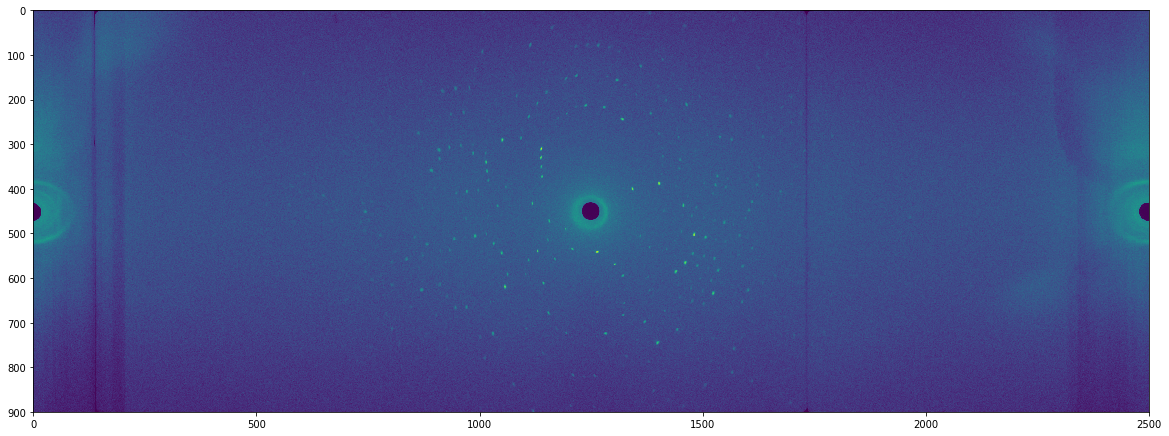

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)))
plt.show()

In [5]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [7]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [9]:
numors = nsx.vector_data()
numors.push_back(data)
peaks = finder.find(numors)
print(peaks.size())

9203


In [8]:
I = 0.0
I2 = 0.0

for peak in peaks:
    intensity = peak.getCorrectedIntensity().getValue()
    I += intensity
    I2 += intensity**2
    
I /= peaks.size()

variance = (I2 - peaks.size()*I*I) / (peaks.size()-1)
std = math.sqrt(variance)

print("average intensity =", I)
print("std intensity     =", std)

average intensity = 217474.79246548485
std intensity     = 200586.50010931876


<IPython.core.display.Javascript object>


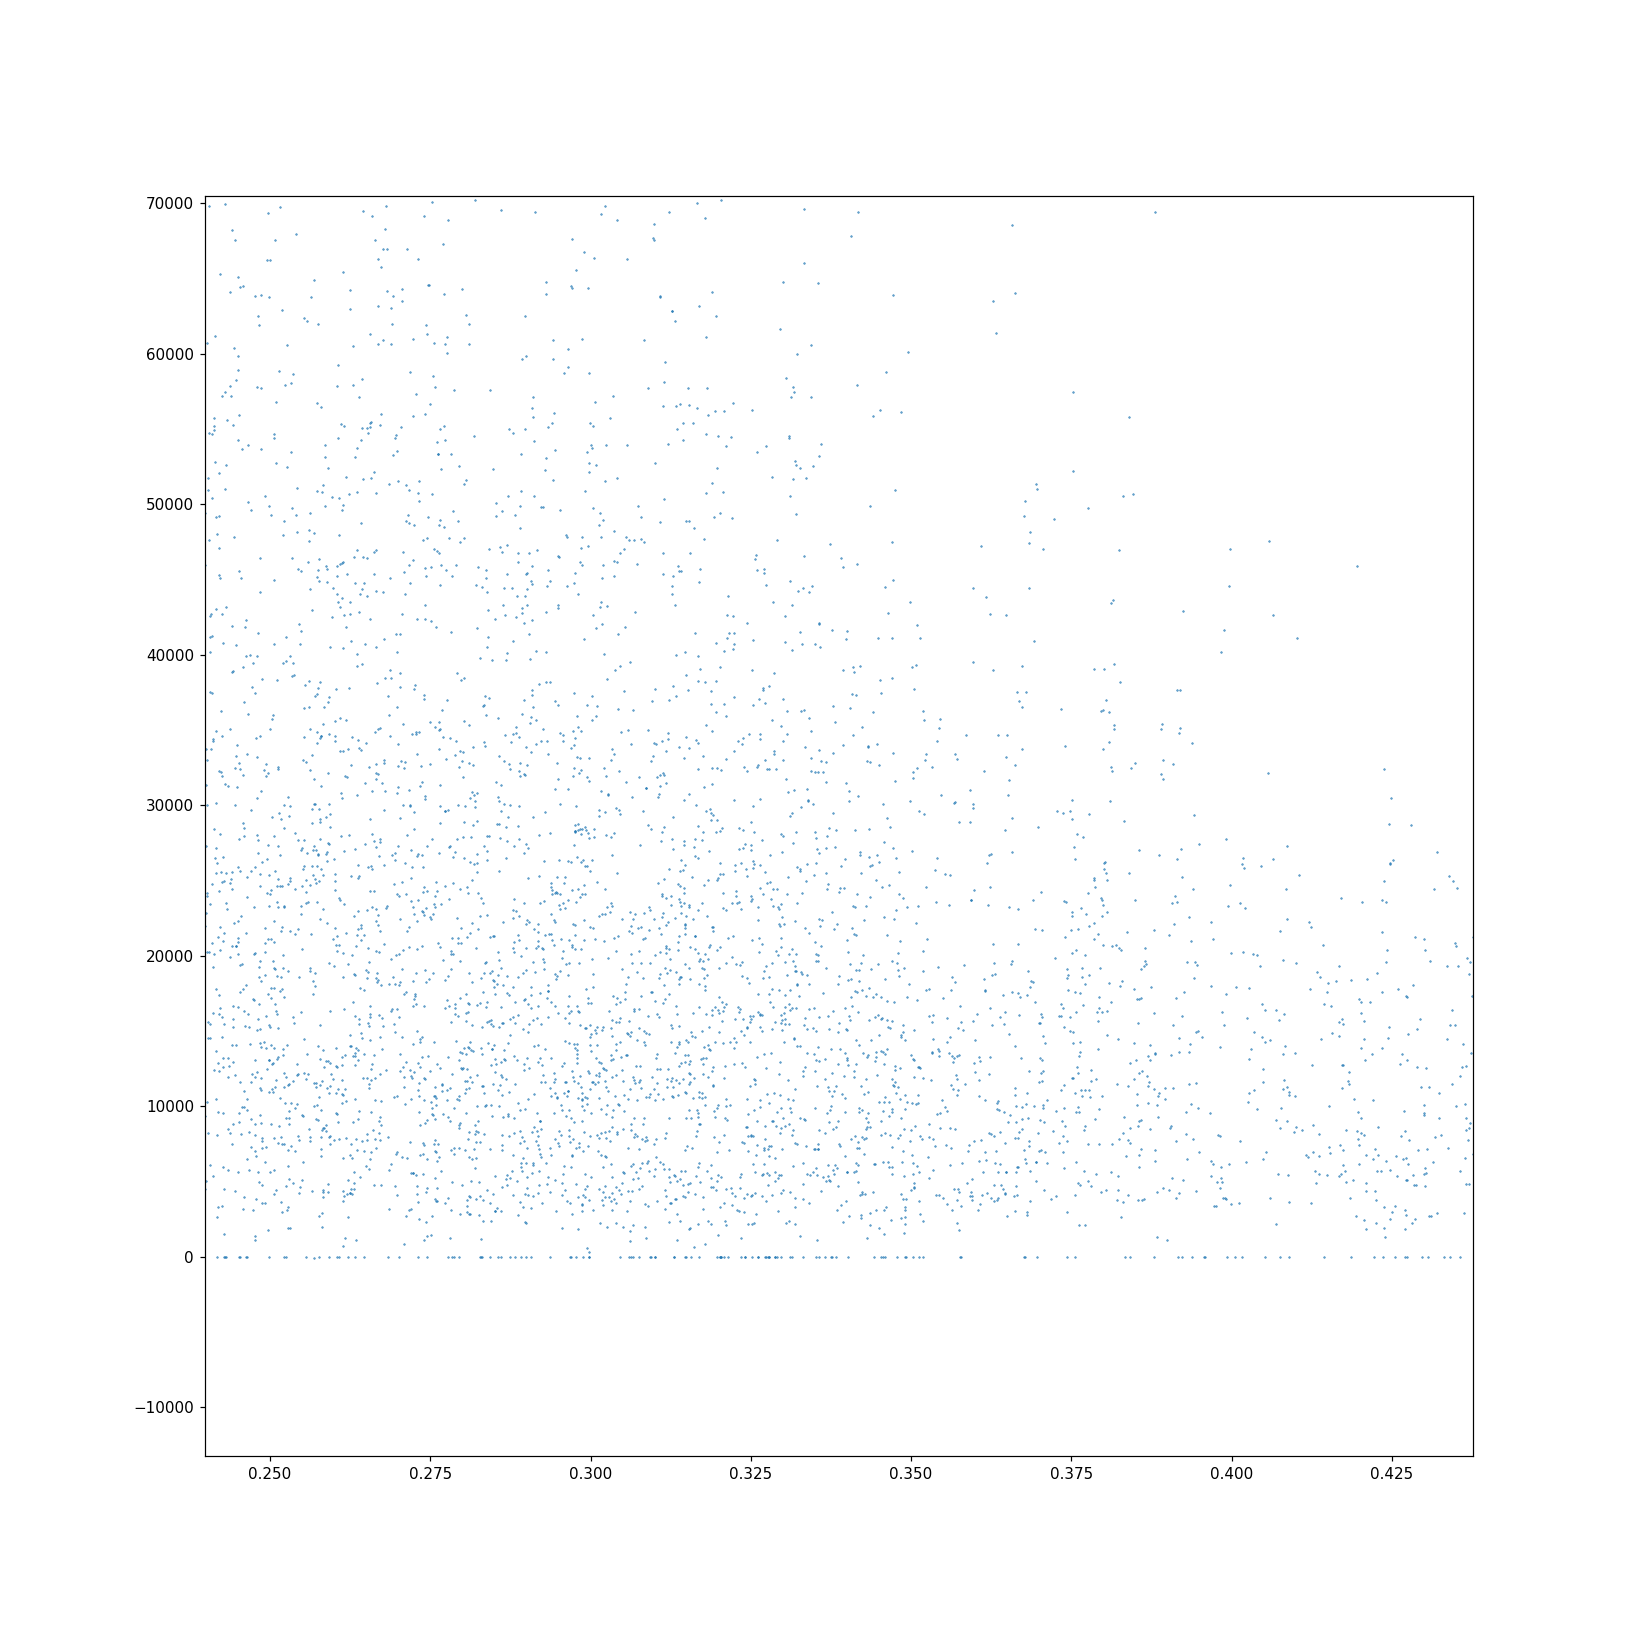

In [14]:
%matplotlib notebook
I = []
q = []


for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().value())
    q.append(np.linalg.norm(peak.getQ().rowVector()))

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()

In [10]:
indexer = nsx.AutoIndexer(expt, nsx.ProgressHandler())

num_to_index = 0

for peak in peaks:
    d = 1.0 / np.linalg.norm(peak.getQ())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = biodiff.getSample()
sample.addUnitCell(uc)

for peak in peaks:
    peak.addUnitCell(uc, True)

predict_peaks(data)

indexing 8201 peaks


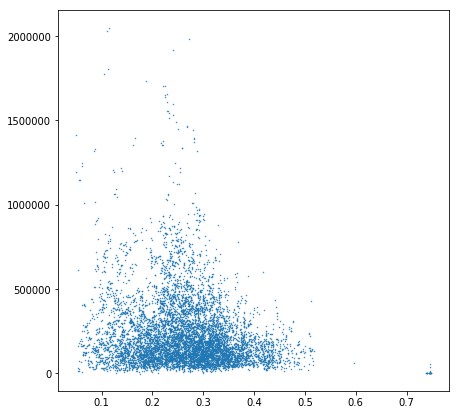

In [11]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(7,7))
plt.scatter(q, I, s=0.2)
plt.show()

8243 peaks


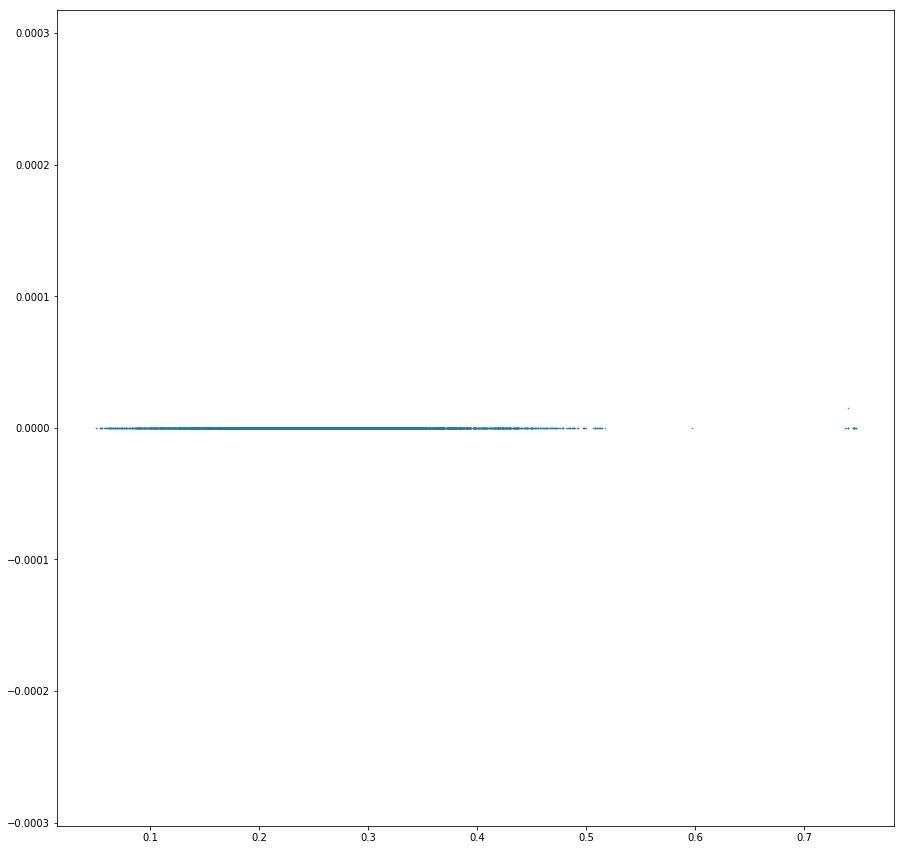

In [12]:
peaks = data.getPeaks()


# apply some cutoffs to the peaks
for peak in peaks:
    if peak.isSelected() != True:
        continue
    if peak.pValue() > 0.001:
        peak.setSelected(False)
        continue


P = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    P.append(peak.pValue())
    q.append(np.linalg.norm(peak.getQ()))
    
print(len(P), "peaks")

plt.figure(figsize=(15,15))
plt.scatter(q, P, s=0.2)
plt.show()

In [13]:
# apply some cutoffs to the peaks
num_peaks = 0
for peak in peaks:
    if peak.isSelected() != True:
        continue
        
    prof = nsx.Profile()
    if prof.fit(peak.getIntegration().getProjectionPeak()) == False:
        peak.setSelected(False)
        continue
        
    num_peaks += 1

print(num_peaks)

3421


[0, 1, 2, 3]
[     0.           9594.80986547  15450.45874439      0.        ]
PROFILE FIT FAILED


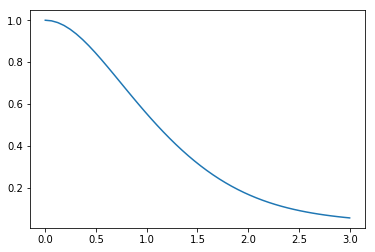

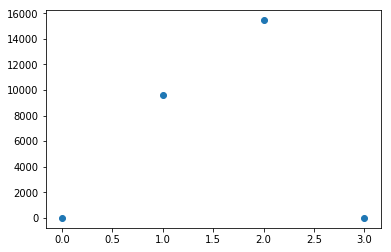

obs:   200362.1488789238
calc:  1.776487469743744
sum:   25045.2686099


In [14]:
n = 3001

peak = peaks[n]
prof = peak.getProfile()

zs = peak.getIntegration().getProjectionPeak().transpose()[0]
qs = [ z for z in zs]
xs = [x for x in range(len(qs))]

print(xs)
print(zs)

ws = np.linspace(xs[0], xs[-1:])

if not prof.fit(zs,1000):
    print("PROFILE FIT FAILED")
    
ys = [prof.evaluate(w) for w in ws ]

plt.plot(ws, ys)
plt.show()

plt.scatter(xs, qs)
plt.show()

calc = [prof.evaluate(x) for x in xs]

print("obs:  ", peak.getRawIntensity().getValue())
print("calc: ", sum(calc))
print("sum:  ", sum(qs))

In [15]:
help(nsx.PeakIntegrator)

Help on class PeakIntegrator in module pynsx:

class PeakIntegrator(builtins.object)
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_PeakIntegrator(...)
 |  
 |  end(self)
 |  
 |  getBlobShape(self, confidence)
 |  
 |  getMeanBackground(self)
 |  
 |  getPeakError(self)
 |  
 |  getPeakIntensity(self)
 |  
 |  getProjection(self)
 |  
 |  getProjectionBackground(self)
 |  
 |  getProjectionPeak(self)
 |  
 |  getRegion(self)
 |  
 |  pValue(self)
 |  
 |  step(self, frame, idx, mask)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to

In [16]:
[1,2,3,4][-1:]

[4]

In [17]:
nsx.PeakCalc(peaks[0])

<pynsx.PeakCalc; proxy of <Swig Object of type 'nsx::PeakCalc *' at 0x7fc2ce5ba0f0> >

In [18]:
compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.982942395286863,
 'CCtrue': 0.9956896260622653,
 'Rmeas': 0.11905017567208671,
 'Rmerge': 0.09579196565226869,
 'Rpim': 0.06659322537849556}

In [19]:
high_q_peaks = []

for peak in peaks:
    if peak.isSelected() == False:
        continue
    if 1.0 / np.linalg.norm(peak.getQ()) < 2.1:
        high_q_peaks.append(peak)
        
print(len(high_q_peaks))
print(compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True))

18
{'CChalf': 0.9847165085694527, 'CCtrue': 0.9961422630936106, 'Rmeas': 0.11905017567208671, 'Rmerge': 0.09579196565226869, 'Rpim': 0.06659322537849556}


In [20]:
for i in range(1):
    print('------------------------------------------')
    print(num_selected_peaks(data.getPeaks()))
    filter_peaks(data.getPeaks())
    remove_deselected(data)
    print(num_selected_peaks(data.getPeaks()))
    predict_peaks(data)
    print(num_selected_peaks(data.getPeaks()))
    print(compute_statistics(data.getPeaks(), nsx.SpaceGroup("P 21 21 21"), True))

------------------------------------------
3421
3403
3403
{'CChalf': 0.9828058650165514, 'CCtrue': 0.9956547504146542, 'Rmeas': 0.11563596729777754, 'Rmerge': 0.09230844766962996, 'Rpim': 0.06660825409959055}


In [21]:
dmin = 2.1
dmax = 48.0

good_peaks = []
all_peaks = data.getPeaks()
filter_peaks(all_peaks)

for peak in all_peaks:
    if not peak.isSelected():
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ())
    if d >= dmin and d <= dmax:
        good_peaks.append(peak)
          
print(len(all_peaks))
print(len(good_peaks))

compute_statistics(good_peaks, nsx.SpaceGroup("P 21 21 21"), True)

3403
3403


{'CChalf': 0.9820343086065783,
 'CCtrue': 0.9954575487567987,
 'Rmeas': 0.11563596729777754,
 'Rmerge': 0.09230844766962996,
 'Rpim': 0.06660825409959055}

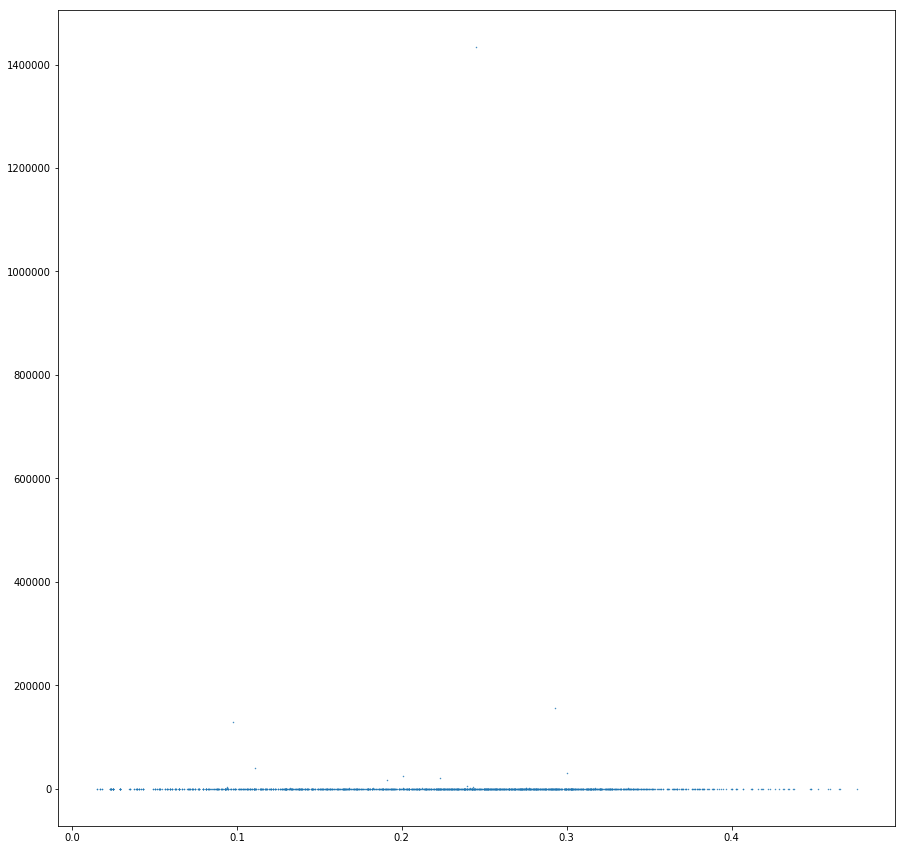

In [22]:
merged = nsx.MergedData(nsx.SpaceGroup("P 21 21 21"), True)

for peak in good_peaks:
    if peak.isSelected():
        merged.addPeak(nsx.PeakCalc(peak))
        
p = []
q = []
        
for peak in merged.getPeaks():
    p.append(peak.chi2()) 
    [[h, k, l]] = peak.getIndex()
    q.append(1.0 / uc.getD(int(h),int(k),int(l)))
        
    
plt.figure(figsize=(15,15))
plt.scatter(q, p, s=0.2)
plt.show()

In [23]:
peak = merged.getPeaks()[1]
raw_peaks = peak.getPeaks()

In [24]:
print(raw_peaks)
print(type(raw_peaks))

(<pynsx.PeakCalc; proxy of <Swig Object of type 'nsx::PeakCalc *' at 0x7fc2c873f120> >,)
<class 'tuple'>


In [25]:
help(nsx.PeakCalc)

Help on class PeakCalc in module pynsx:

class PeakCalc(builtins.object)
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_PeakCalc(...)
 |  
 |  averagePeaks(self, tree, distance, min_axis=2.0)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __swig_getmethods__ = {'_frame': <built-in function PeakCalc__frame_ge...
 |  
 |  __swig_setmethods__ = {'_frame': <built-in function PeakC

In [26]:
help(uc)

Help on UnitCell in module pynsx object:

class UnitCell(Basis)
 |  Method resolution order:
 |      UnitCell
 |      Basis
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_UnitCell(...)
 |  
 |  copyMatrices(self, other)
 |  
 |  generateReflectionsInShell(self, dmin, dmax, wavelength)
 |  
 |  generateReflectionsInSphere(self, dstarmax)
 |  
 |  getAVector(self)
 |  
 |  getAngle(self, *args)
 |  
 |  getBVector(self)
 |  
 |  getBravaisTypeSymbol(self)
 |  
 |  getBusingLevyB(self)
 |  
 |  getBusingLevyU(self)
 |  
 |  getCVector(self)
 |  
 |  getD(self, h, k, l)
 |  
 |  getHKLTolerance(self)
 |  
 |  getMaterial(self)
 |  
 |  getName(self)
 |  
 |  getReciprocalAVector(self)
 |  
 |  getRe

In [27]:
peak.getIndex()

array([[ 0,  0, 26]], dtype=int32)

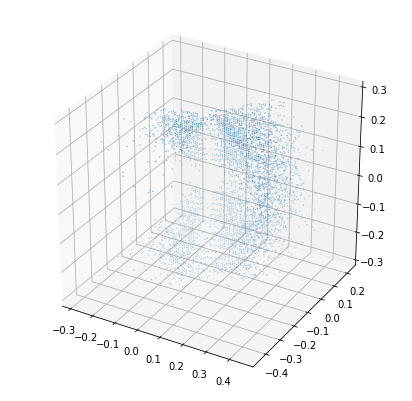

In [28]:
peaks = data.getPeaks()
qs = []

for peak in peaks:
    qs.append(peak.getQ()[0])
    
xs = [ q[0] for q in qs ]
ys = [ q[1] for q in qs ]
zs = [ q[2] for q in qs ]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, s=0.1)
plt.show()
      

In [29]:
hs = []
ks = []
ls = []
error = []
frame = []

the_peaks = [peaks[0]]

for peak in peaks:
    if not peak.isSelected():
        continue
    
    center = peak.getShape().getAABBCenter().transpose()[0]
    
    q = peak.getQ()
    hkl = peak.getMillerIndices()[0]
    
    uc = peak.activeUnitCell()
    g = uc.getMetricTensor()
    
    real_hkl = uc.fromReciprocalStandard(q)[0]
    
    d = real_hkl-hkl
    
    if (np.linalg.norm(d) > 0.5):
        continue
    
    #print(hkl)
    #print(real_hkl)
    
    hs.append(d[0])
    ks.append(d[1])
    ls.append(d[2])
    error.append(np.linalg.norm(d))
    frame.append(center[2])

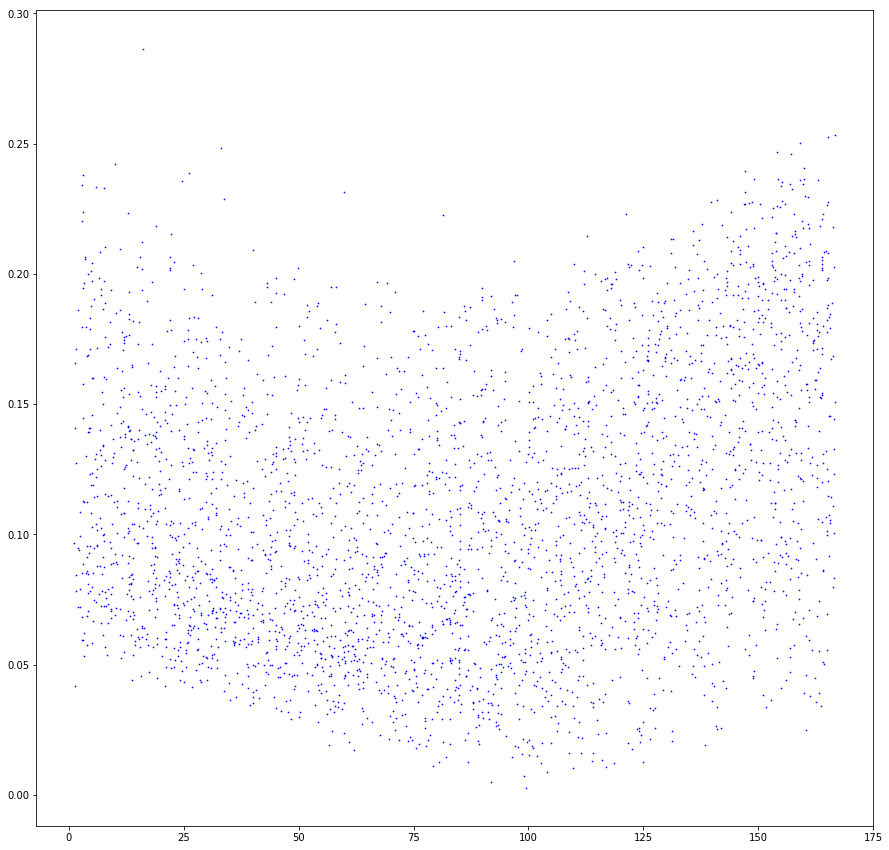

In [30]:
plt.figure(figsize=(15,15))
#plt.scatter(frame, hs, s=0.5, color='r')
#plt.scatter(frame, ks, s=0.5, color='g')
#plt.scatter(frame, ls, s=0.5, color='b')
plt.scatter(frame, error, s=0.5, color='b')
plt.show()